In [1]:
import os
import meld_graph
import meld_graph.models
import meld_graph.experiment
import meld_graph.dataset
import meld_graph.data_preprocessing
import meld_graph.evaluation

from meld_graph.dataset import GraphDataset
from meld_classifier.meld_cohort import MeldCohort, MeldSubject

from meld_graph.evaluation import Evaluator
import numpy as np
import matplotlib.pyplot as plt 
import pandas as pd

import umap




Setting MELD_DATA_PATH to /rds/project/kw350/rds-kw350-meld/meld_data/Data
Setting BASE_PATH to /rds/project/kw350/rds-kw350-meld/meld_data/Data
Setting EXPERIMENT_PATH to /rds/project/kw350/rds-kw350-meld/experiments/co-ripa1/
Setting FS_SUBJECTS_PATH to 
Setting EXPERIMENT_PATH to /rds/project/kw350/rds-kw350-meld/experiments_graph/kw350


In [2]:
# load experiment
model_path = '/rds/project/kw350/rds-kw350-meld/experiments_graph/kw350/23-10-30_FOPF_dcop/s_0/fold_all'
exp = meld_graph.experiment.Experiment.from_folder(model_path)
exp.data_parameters["augment_data"] = {}

#load trainval dataset
split = "test"
save_prediction_suffix=""
model_name = 'best_model'
subjects = exp.data_parameters["test_ids"]


features = exp.data_parameters["features"]
cohort = MeldCohort(
        hdf5_file_root=exp.data_parameters["hdf5_file_root"],
        dataset=exp.data_parameters["dataset"],
    )
# dataset = GraphDataset(subjects, cohort, exp.data_parameters, mode="test")
    
# create evaluator
eva = Evaluator(
    experiment=exp,
    checkpoint_path=model_path,
    make_images=False,
    # dataset=dataset,
    # save_dir=save_dir,
    cohort=cohort,
    subject_ids=subjects,
    mode="test",
    thresh_and_clust=False,
    model_name=model_name
)


Initialised Experiment 23-10-30_FOPF_dcop/s_0
Creating model


/rds/project/kw350/rds-kw350-meld/experiments_graph/kw350/23-10-30_FOPF_dcop/s_0/fold_all


Creating ensemble model
Loading ensemble model weights from checkpoint /rds/project/kw350/rds-kw350-meld/experiments_graph/kw350/23-10-30_FOPF_dcop/s_0/fold_all/best_model.pt
Predicting model without dropout


In [ ]:
# save fingerprints and confidence in csv for dataset if don't already exists
file_finger = os.path.join(eva.save_dir, f'results_{model_name}', f'fingerprints{save_prediction_suffix}.csv')
file_conf =  os.path.join(eva.save_dir, f'results_{model_name}', f'confidence{save_prediction_suffix}.csv')
    
if not os.path.isfile(file_finger):
    print('compute fingerprints')
    eva.save_fingerprints_csv(suffix=save_prediction_suffix)
if not os.path.isfile(file_conf):
    print('compute confidence')
    eva.save_confidence_csv(suffix=save_prediction_suffix)

### Organise data for UMAP

In [3]:
file = os.path.join(eva.save_dir, f'results_{model_name}', f'fingerprints{save_prediction_suffix}.csv')
df= pd.read_csv(file)
df.head()

,Unnamed: 0,subject_id,cluster_id,detected,mean_salient_.combat.on_lh.pial.K_filtered.sm20.mgh,std_salient_.combat.on_lh.pial.K_filtered.sm20.mgh,mean_salient_.combat.on_lh.thickness.sm3.mgh,std_salient_.combat.on_lh.thickness.sm3.mgh,mean_salient_.combat.on_lh.thickness_regression.sm3.mgh,std_salient_.combat.on_lh.thickness_regression.sm3.mgh,...,mean_salient_.inter_z.asym.intra_z.combat.on_lh.gm_FLAIR_0.5.sm3.mgh,std_salient_.inter_z.asym.intra_z.combat.on_lh.gm_FLAIR_0.5.sm3.mgh,mean_salient_.inter_z.asym.intra_z.combat.on_lh.gm_FLAIR_0.25.sm3.mgh,std_salient_.inter_z.asym.intra_z.combat.on_lh.gm_FLAIR_0.25.sm3.mgh,mean_salient_.inter_z.asym.intra_z.combat.on_lh.gm_FLAIR_0.sm3.mgh,std_salient_.inter_z.asym.intra_z.combat.on_lh.gm_FLAIR_0.sm3.mgh,mean_salient_.inter_z.asym.intra_z.combat.on_lh.wm_FLAIR_0.5.sm3.mgh,std_salient_.inter_z.asym.intra_z.combat.on_lh.wm_FLAIR_0.5.sm3.mgh,mean_salient_.inter_z.asym.intra_z.combat.on_lh.wm_FLAIR_1.sm3.mgh,std_salient_.inter_z.asym.intra_z.combat.on_lh.wm_FLAIR_1.sm3.mgh
0,0,MELD_H2_15T_FCD_0003,1.0,True,1.882802,1.818243,-0.382618,1.305569,-0.477661,1.390283,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0,MELD_H2_15T_FCD_0005,1.0,False,-0.204010,0.744992,-1.180305,0.495857,-1.207342,0.618326,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0,MELD_H2_15T_FCD_0007,1.0,True,5.697721,2.637072,1.457436,1.370817,1.870232,1.555505,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0,MELD_H2_15T_FCD_0008,1.0,False,2.785091,0.205065,1.959629,0.574426,2.251197,0.643094,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0,MELD_H2_15T_FCD_0009,1.0,True,3.330286,1.075389,2.378807,0.916128,2.648404,0.872805,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [4]:
# add demographic info
age_array=[]
sex_array=[]
histo_array=[]
site_array=[]
flair_array=[]
group_array=[]
sf_array=[]
mri_neg_array=[]
for r, row in df.iterrows():
    subj = MeldSubject(row['subject_id'], cohort)
    if '_FCD_' in row['subject_id']:
        group_array.append('patient')
    else:
        group_array.append('control')
    age, sex, histo, site, sf, mri_neg = subj.get_demographic_features(["Age at preoperative", "Sex", "Histology", "Site", "Seizure free","MRI negative"])
    age_array.append(age)
    sex_array.append(sex)
    histo_array.append(histo)
    site_array.append(site)
    sf_array.append(sf)
    mri_neg_array.append(mri_neg)
    # add FLAIR
    if row['mean_salient_.combat.on_lh.gm_FLAIR_0.sm3.mgh']==0:
        flair_array.append(False)
    else:
        flair_array.append(True)

    
df['age']=age_array
df['sex']=sex_array
df['histo']=histo_array
df['site']=site_array
df['FLAIR']=flair_array
df['seizure_freedom']=sf_array
df['mri_neg']= mri_neg_array

df.head()

,Unnamed: 0,subject_id,cluster_id,detected,mean_salient_.combat.on_lh.pial.K_filtered.sm20.mgh,std_salient_.combat.on_lh.pial.K_filtered.sm20.mgh,mean_salient_.combat.on_lh.thickness.sm3.mgh,std_salient_.combat.on_lh.thickness.sm3.mgh,mean_salient_.combat.on_lh.thickness_regression.sm3.mgh,std_salient_.combat.on_lh.thickness_regression.sm3.mgh,...,std_salient_.inter_z.asym.intra_z.combat.on_lh.wm_FLAIR_0.5.sm3.mgh,mean_salient_.inter_z.asym.intra_z.combat.on_lh.wm_FLAIR_1.sm3.mgh,std_salient_.inter_z.asym.intra_z.combat.on_lh.wm_FLAIR_1.sm3.mgh,age,sex,histo,site,FLAIR,seizure_freedom,mri_neg
0,0,MELD_H2_15T_FCD_0003,1.0,True,1.882802,1.818243,-0.382618,1.305569,-0.477661,1.390283,...,NaN,NaN,NaN,10.0,0.0,NaN,H2,True,NaN,0.0
1,0,MELD_H2_15T_FCD_0005,1.0,False,-0.204010,0.744992,-1.180305,0.495857,-1.207342,0.618326,...,NaN,NaN,NaN,20.0,1.0,NaN,H2,True,NaN,0.0
2,0,MELD_H2_15T_FCD_0007,1.0,True,5.697721,2.637072,1.457436,1.370817,1.870232,1.555505,...,NaN,NaN,NaN,4.0,1.0,FCD_2B,H2,True,1.0,0.0
3,0,MELD_H2_15T_FCD_0008,1.0,False,2.785091,0.205065,1.959629,0.574426,2.251197,0.643094,...,NaN,NaN,NaN,10.0,1.0,NaN,H2,True,NaN,0.0
4,0,MELD_H2_15T_FCD_0009,1.0,True,3.330286,1.075389,2.378807,0.916128,2.648404,0.872805,...,NaN,NaN,NaN,18.0,1.0,NaN,H2,True,NaN,0.0


In [5]:
#add confidence
file_conf = os.path.join(eva.save_dir, f'results_{model_name}', f'confidence{save_prediction_suffix}.csv')
df_conf= pd.read_csv(file_conf)

confidence_array=[]
for r, row in df.iterrows():
    subject_id = row['subject_id']
    cluster_id = row['cluster_id']
    confidence = df_conf[(df_conf['subject_id']==subject_id)&(df_conf['cluster_id']==cluster_id)]['confidence_lesion'].values[0]
    confidence_array.append(confidence)
    
df['confidence']=confidence_array

df.head()

,Unnamed: 0,subject_id,cluster_id,detected,mean_salient_.combat.on_lh.pial.K_filtered.sm20.mgh,std_salient_.combat.on_lh.pial.K_filtered.sm20.mgh,mean_salient_.combat.on_lh.thickness.sm3.mgh,std_salient_.combat.on_lh.thickness.sm3.mgh,mean_salient_.combat.on_lh.thickness_regression.sm3.mgh,std_salient_.combat.on_lh.thickness_regression.sm3.mgh,...,mean_salient_.inter_z.asym.intra_z.combat.on_lh.wm_FLAIR_1.sm3.mgh,std_salient_.inter_z.asym.intra_z.combat.on_lh.wm_FLAIR_1.sm3.mgh,age,sex,histo,site,FLAIR,seizure_freedom,mri_neg,confidence
0,0,MELD_H2_15T_FCD_0003,1.0,True,1.882802,1.818243,-0.382618,1.305569,-0.477661,1.390283,...,NaN,NaN,10.0,0.0,NaN,H2,True,NaN,0.0,0.112629
1,0,MELD_H2_15T_FCD_0005,1.0,False,-0.204010,0.744992,-1.180305,0.495857,-1.207342,0.618326,...,NaN,NaN,20.0,1.0,NaN,H2,True,NaN,0.0,0.100994
2,0,MELD_H2_15T_FCD_0007,1.0,True,5.697721,2.637072,1.457436,1.370817,1.870232,1.555505,...,NaN,NaN,4.0,1.0,FCD_2B,H2,True,1.0,0.0,0.982421
3,0,MELD_H2_15T_FCD_0008,1.0,False,2.785091,0.205065,1.959629,0.574426,2.251197,0.643094,...,NaN,NaN,10.0,1.0,NaN,H2,True,NaN,0.0,0.522307
4,0,MELD_H2_15T_FCD_0009,1.0,True,3.330286,1.075389,2.378807,0.916128,2.648404,0.872805,...,NaN,NaN,18.0,1.0,NaN,H2,True,NaN,0.0,0.861583


## Analysis with UMAP

In [6]:
def mscatter(x,y,ax=None,label=None, m=None, s=20 ,**kw):
    import matplotlib.markers as mmarkers
    if not ax: ax=plt.gca()
    sc = ax.scatter(x,y,**kw, s=s,label=label)
    if (m is not None) and (len(m)==len(x)):
        paths = []
        for marker in m:
            if isinstance(marker, mmarkers.MarkerStyle):
                marker_obj = marker
            else:
                marker_obj = mmarkers.MarkerStyle(marker)
            path = marker_obj.get_path().transformed(
                        marker_obj.get_transform())
            paths.append(path)
        sc.set_paths(paths)
    #ax.set_xlim([-5,12.5])
    #ax.set_ylim([0,15])
    #plt.axis('off')
    return sc

def format_umap_axes(ax):
    # Hide the right and top spines
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)

    # Only show ticks on the left and bottom spines
    ax.yaxis.set_ticks_position('left')
    ax.xaxis.set_ticks_position('bottom')
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xlabel('UMAP 1')
    ax.set_ylabel('UMAP 2')
    return

In [7]:
#select submatrix for analysis
subdf=df.copy()
# subdf=subdf[subdf['FLAIR']==True].copy()
subdf = subdf.reset_index()

# select mean features
keys = [feature for feature in subdf.keys() if 'mean_salient_.inter_z.' in feature]
print(len(keys))
X = subdf[keys]
X=np.array(X)
#set missing values to 0
X=np.nan_to_num(X)

# reduce dimension with umap
my_umap=umap.UMAP(
    n_neighbors=10,
    min_dist=0.5,
    n_components=2,
    random_state=0,
)

clusterable_embedding = np.zeros((len(X[:,0]),2))
clusterable_embedding = my_umap.fit_transform(X)
clusterable_embedding[:,1] = -clusterable_embedding[:,1]
 

22


/home/co-ripa1/.conda/envs/meld_graph/lib/python3.9/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


In [8]:
len(subdf)

338

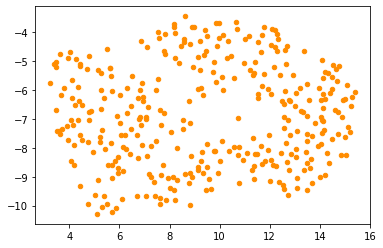

In [9]:
## plot embedding
plt.scatter(clusterable_embedding[:, 0], 
         clusterable_embedding[:, 1], color='darkorange', s=20,)

mean_salient_.inter_z.intra_z.combat.on_lh.w-g.pct.sm3.mgh
mean_salient_.inter_z.intra_z.combat.on_lh.wm_FLAIR_0.5.sm3.mgh
mean_salient_.inter_z.intra_z.combat.on_lh.wm_FLAIR_1.sm3.mgh


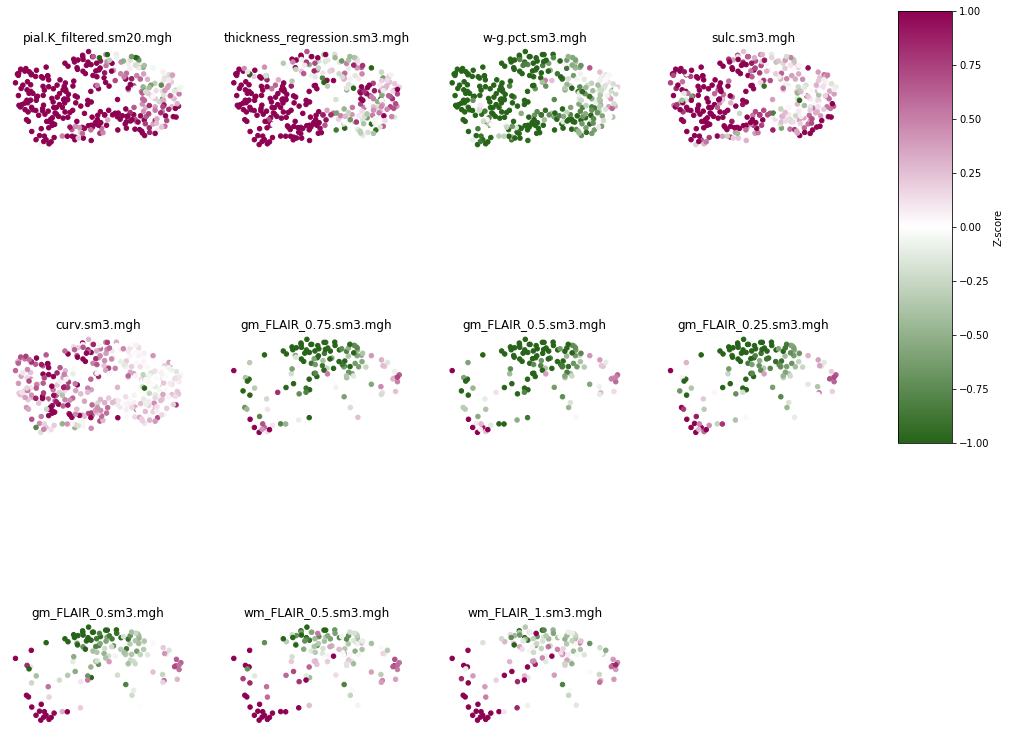

In [10]:
# color by feature
from matplotlib.gridspec import GridSpec
import matplotlib

cmap_hex = matplotlib.colors.LinearSegmentedColormap.from_list('grpr',colors=['#276419','#FFFFFF','#8E0152',])

sub_keys = ['mean_salient_'+feature for feature in features if 'inter_z.intra_z.combat' in feature ]
titles = [feature.split('.combat.on_lh.')[-1] for feature in sub_keys]
#plot features distribution
fig = plt.figure(figsize=(15,15))
gs1 = GridSpec(3,4)
axs = []

for i, key in enumerate(sub_keys): 
    overlay = X[:, np.where(np.array(keys) == key)[0][0]]
    title=titles[i]
    axs.append(fig.add_subplot(gs1[i]))
    if 'FLAIR' in title:
        mask=overlay!=0
        s= mscatter(clusterable_embedding[:, 0][mask],
                    clusterable_embedding[:, 1][mask], c=overlay[mask],
                    cmap=cmap_hex, 
                ax=axs[i], s=20, vmin=-1, vmax=1)
    else:
        s= mscatter(clusterable_embedding[:, 0], clusterable_embedding[:, 1],
                    c=overlay, cmap=cmap_hex, 
                ax=axs[i], s=20, vmin=-1, vmax=1)
    
    axs[i].set_title(title)
    axs[i].set_aspect(1)
    axs[i].set_axis_off()
    if 'w' in key:
        print(key)
        #fig.colorbar(s,ax=axs[i])
        
cax = fig.add_axes([0.95, 0.45, 0.05, 0.4])
fig.colorbar(s,cax=cax,label='Z-score')



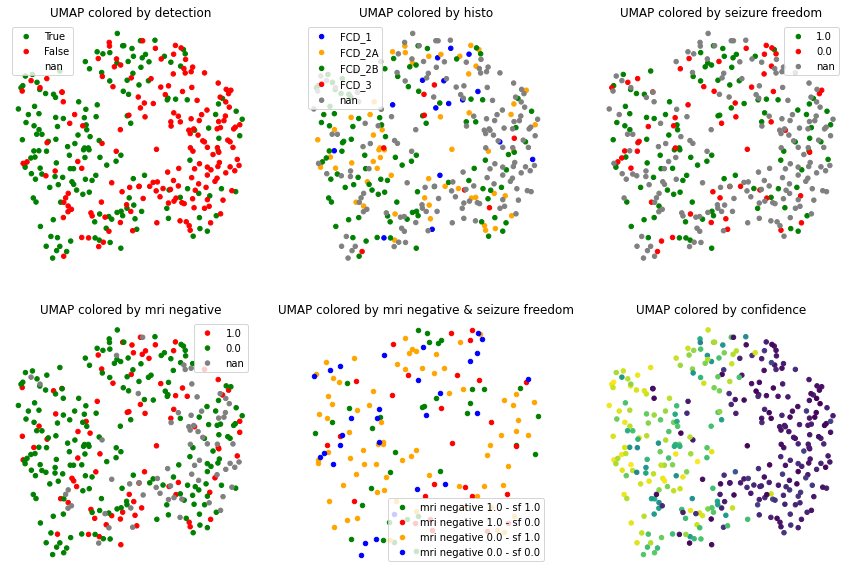

In [56]:
from sklearn import preprocessing
#plot umap with demographic

fig = plt.figure(figsize=(15,10))
gs1 = GridSpec(2,3)
axs = []

i=0

# color by detection
axs.append(fig.add_subplot(gs1[i]))
pal = {'True':'green', 'False':'red', 'nan':'grey'}
labels =  {'True':'TP', 'False':'FP', 'nan':'NaN'}
c = [ pal[str(val)] for val in subdf['detected']]
for key in pal:
    mask = (subdf['detected'].values.astype(str)==key).astype(bool)
    axs[i].scatter(clusterable_embedding[mask, 0], clusterable_embedding[mask, 1], c=[pal[key]]*mask.sum(), s=20, label=labels[key])
axs[i].set_title('UMAP colored by detection')
axs[i].legend()
axs[i].set_axis_off()
i=i+1

# # color by age
# c = subdf['age'].values
# plt.figure()
# plt.scatter(clusterable_embedding[:, 0], 
#          clusterable_embedding[:, 1], c=c,cmap = 'viridis', s=20,)
# plt.title('UMAP colored by age')

# # color by site
# le = preprocessing.LabelEncoder()
# le.fit(subdf['site'])
# c = le.transform(subdf['site'])
# plt.figure()
# plt.scatter(clusterable_embedding[:, 0], 
#          clusterable_embedding[:, 1], c=c, cmap = 'viridis', s=20,)
# plt.title('UMAP colored by site')

# color by histopathology
axs.append(fig.add_subplot(gs1[i]))
pal = {'FCD_1':'blue', 'FCD_2A':'orange', 'FCD_2B':'green', 'FCD_3':'red', 'nan':'grey'}
for key in pal:
    mask = (subdf['histo'].values.astype(str)==key).astype(bool)
    axs[i].scatter(clusterable_embedding[mask, 0], clusterable_embedding[mask, 1], c=[pal[key]]*mask.sum(), s=20, label=key)
axs[i].set_title('UMAP colored by histo')
axs[i].legend()
axs[i].set_axis_off()
i=i+1

# color by seizure freedom
axs.append(fig.add_subplot(gs1[i]))
pal = {'1.0':'green', '0.0':'red', 'nan':'grey'}
labels =  {'1.0':'sf', '0.0':'not sf', 'nan':'NaN'}
for key in pal:
    mask = (subdf['seizure_freedom'].values.astype(str)==key).astype(bool)
    axs[i].scatter(clusterable_embedding[mask, 0], clusterable_embedding[mask, 1], c=[pal[key]]*mask.sum(), s=20, label=labels[key])
axs[i].set_title('UMAP colored by seizure freedom')
axs[i].legend()
axs[i].set_axis_off()
i=i+1

# color by mri_neg
axs.append(fig.add_subplot(gs1[i]))
pal = {'1.0':'red', '0.0':'green', 'nan':'grey'}
labels =  {'1.0':'MRI negative', '0.0':'MRI positive', 'nan':'NaN'}
for key in pal:
    mask = (subdf['mri_neg'].values.astype(str)==key).astype(bool)
    axs[i].scatter(clusterable_embedding[mask, 0], clusterable_embedding[mask, 1], c=[pal[key]]*mask.sum(), s=20, label=labels[key])
axs[i].set_title('UMAP colored by mri negative')
axs[i].legend()
axs[i].set_axis_off()
i=i+1

# color by mri_neg
axs.append(fig.add_subplot(gs1[i]))
j=0
pal=['green', 'red', 'orange', 'blue']
labels =  {'MRI neg - fs', ' MRI neg - not sf', 'MRI pos - sf', 'MRI pos - not sf'}
for mri in [1.0, 0.0]:
    for sf in [1.0, 0.0]:
        mask =  ((subdf['mri_neg']==mri) & (subdf['seizure_freedom']==sf)).astype(bool)
        axs[i].scatter(clusterable_embedding[mask, 0], clusterable_embedding[mask, 1], color=pal[j], s=20, label = f'mri negative {mri} - sf {sf}')
        j=j+1
axs[i].legend()
axs[i].set_title('UMAP colored by mri negative & seizure freedom')
axs[i].set_axis_off()
i=i+1

# color by confidence
axs.append(fig.add_subplot(gs1[i]))
c = subdf['confidence'].values
axs[i].scatter(clusterable_embedding[:, 0], clusterable_embedding[:, 1], c=c, cmap = 'viridis', s=20,)
axs[i].set_title('UMAP colored by confidence')
axs[i].set_axis_off()


In [38]:
import matplotlib.pyplot as plt

### Analysis with PCA  (old)

In [39]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

#select submatrix for analysis
subdf=df.copy()
# subdf=subdf[subdf['FLAIR']==True].copy()
subdf = subdf.reset_index()

# select mean features
keys = [feature for feature in subdf.keys() if 'mean_salient_.inter_z' in feature ]
len(keys)
X = subdf[keys]
X=np.array(X)
#set missing values to 0
X=np.nan_to_num(X)

#scale
# X = StandardScaler().fit_transform(X) # normalizing the features

pca= PCA(n_components=2)
principalComponents = pca.fit_transform(X)
 

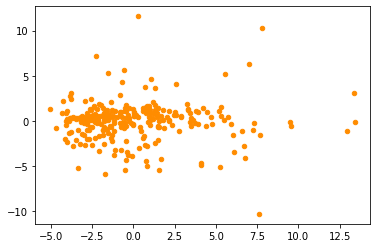

In [44]:
## plot embedding
plt.scatter(principalComponents[:, 0], 
         principalComponents[:, 1], color='darkorange', s=20,)

mean_salient_.inter_z.intra_z.combat.on_lh.w-g.pct.sm3.mgh
mean_salient_.inter_z.intra_z.combat.on_lh.wm_FLAIR_0.5.sm3.mgh
mean_salient_.inter_z.intra_z.combat.on_lh.wm_FLAIR_1.sm3.mgh


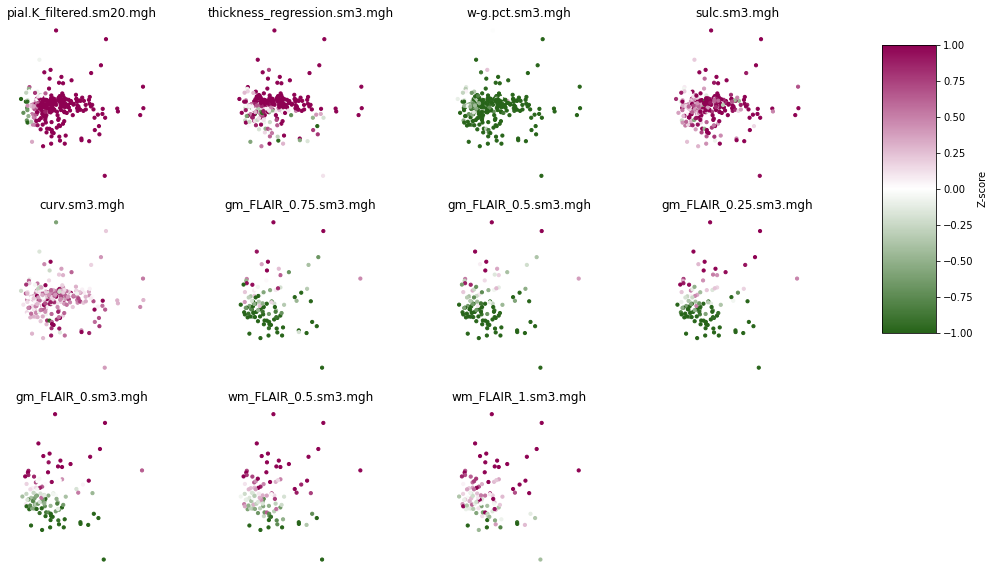

In [45]:
# color by feature
from matplotlib.gridspec import GridSpec
import matplotlib

cmap_hex = matplotlib.colors.LinearSegmentedColormap.from_list('grpr',colors=['#276419','#FFFFFF','#8E0152',])

sub_keys = ['mean_salient_'+feature for feature in features if 'inter_z.intra_z.combat' in feature ]
titles = [feature.split('.combat.on_lh.')[-1] for feature in sub_keys]
#plot features distribution
fig = plt.figure(figsize=(15,10))
gs1 = GridSpec(3,4)
axs = []

for i, key in enumerate(sub_keys): 
    overlay = X[:, np.where(np.array(keys) == key)[0][0]]
    title=titles[i]
    axs.append(fig.add_subplot(gs1[i]))
    if 'FLAIR' in title:
        mask=overlay!=0
        s= mscatter(principalComponents[:, 0][mask],
                    principalComponents[:, 1][mask], c=overlay[mask],
                    cmap=cmap_hex, 
                ax=axs[i], s=10, vmin=-1, vmax=1)
    else:
        s= mscatter(principalComponents[:, 0], principalComponents[:, 1],
                    c=overlay, cmap=cmap_hex, 
                ax=axs[i], s=10, vmin=-1, vmax=1)
    
    axs[i].set_title(title)
    axs[i].set_aspect(1)
    axs[i].set_axis_off()
    if 'w' in key:
        print(key)
        #fig.colorbar(s,ax=axs[i])
        
cax = fig.add_axes([0.95, 0.45, 0.05, 0.4])
fig.colorbar(s,cax=cax,label='Z-score')



Text(0.5, 1.0, 'PCA colored by confidence')

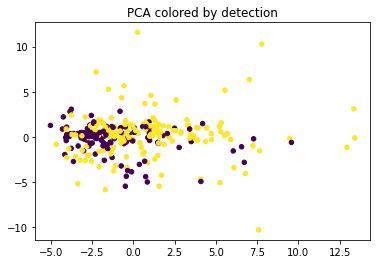

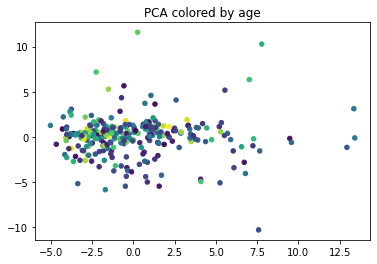

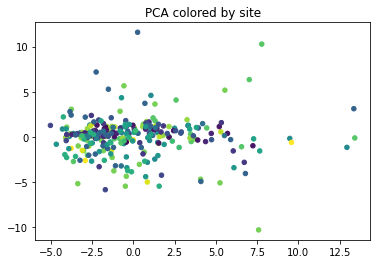

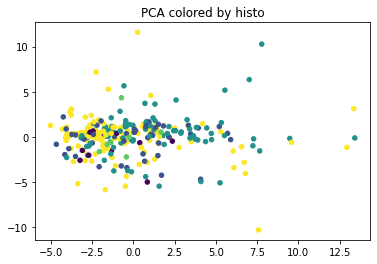

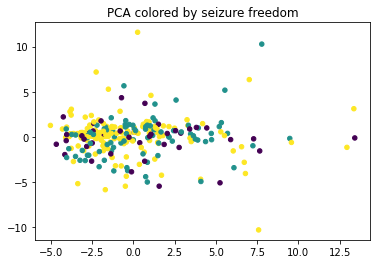

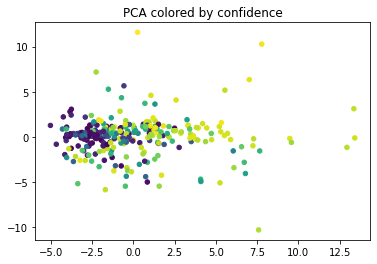

In [51]:
from sklearn import preprocessing
#plot umap with demographic

# color by detection
le = preprocessing.LabelEncoder()
le.fit(subdf['detected'])
c = le.transform(subdf['detected'])
plt.figure()
plt.scatter(principalComponents[:, 0], 
         principalComponents[:, 1], c=c, cmap = 'viridis', s=20,)
plt.title('PCA colored by detection')

# color by age
c = subdf['age'].values
plt.figure()
plt.scatter(principalComponents[:, 0], 
         principalComponents[:, 1], c=c,cmap = 'viridis', s=20,)
plt.title('PCA colored by age')

# color by site
le = preprocessing.LabelEncoder()
le.fit(subdf['site'])
c = le.transform(subdf['site'])
plt.figure()
plt.scatter(principalComponents[:, 0], 
         principalComponents[:, 1], c=c, cmap = 'viridis', s=20,)
plt.title('PCA colored by site')

# color by histopathology
le = preprocessing.LabelEncoder()
le.fit(subdf['histo'])
c = le.transform(subdf['histo'])
plt.figure()
plt.scatter(principalComponents[:, 0], 
         principalComponents[:, 1], c=c, cmap = 'viridis', s=20,)
plt.title('PCA colored by histo')

# color by seizure freedom
le = preprocessing.LabelEncoder()
le.fit(subdf['seizure_freedom'])
c = le.transform(subdf['seizure_freedom'])
plt.figure()
plt.scatter(principalComponents[:, 0], 
         principalComponents[:, 1], c=c, cmap = 'viridis', s=20,)
plt.title('PCA colored by seizure freedom')

# color by confidence
c = subdf['confidence'].values
plt.figure()
plt.scatter(principalComponents[:, 0], 
         principalComponents[:, 1], c=c,cmap = 'viridis', s=20,)
plt.title('PCA colored by confidence')
